In [0]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [69]:
!pip install --upgrade pandas
!pip install arviz
!pip install watermark

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)


#### Code 4.1
Normal by addition:Any process that adds together random values from the same distribution converges to
a normal. But it’s not easy to grasp why addition should result in a bell curve of sums. Here’s a conceptual way to think of the process. Whatever the average value of the source distribution, each sample from it can be thought of as a fluctuation from that average value. When we begin to add these fluctuations together, they also begin to cancel one another out. A large positive fluctuation will cancel a large negative one. The more terms in the sum, the more chances for each fluctuation to be canceled by another, or by a series of smaller ones in the opposite direction. 
It doesn’t matter what shape the underlying distribution possesses.

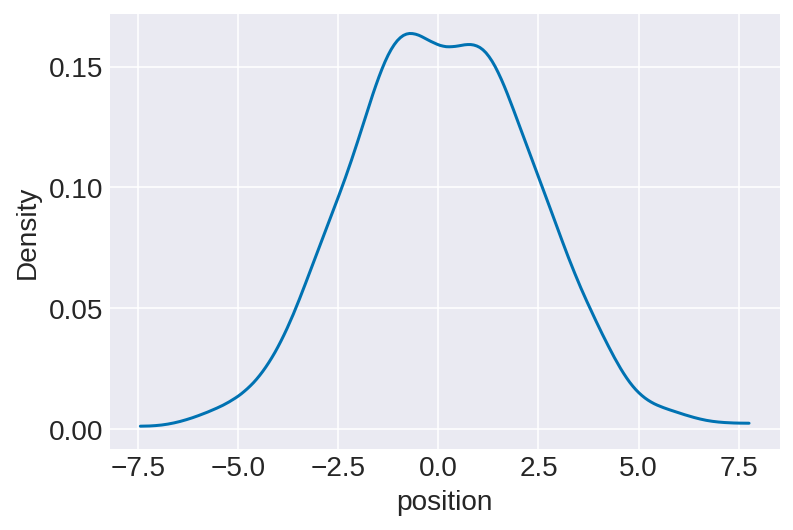

In [70]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
pm.kdeplot(pos)
plt.xlabel('position', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 4.2 and 4.3
Normal by multiplication
The interacting growth deviations, as long as they are sufficiently small, converge to a Gauss- ian distribution.

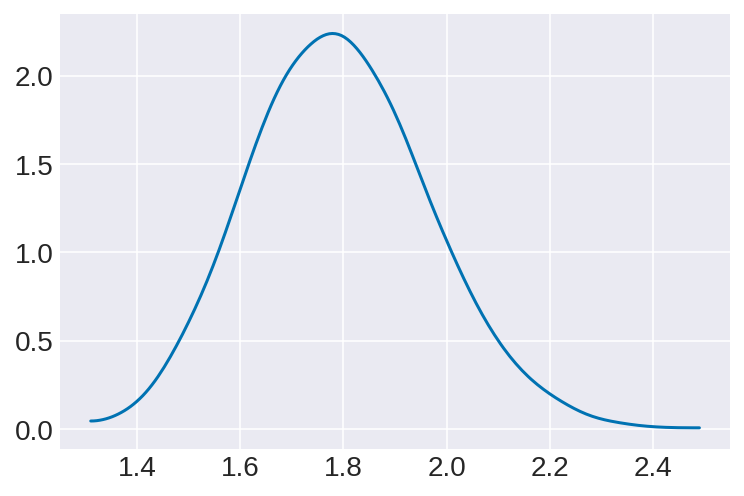

In [71]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pm.kdeplot(pos);

#### Code 4.4

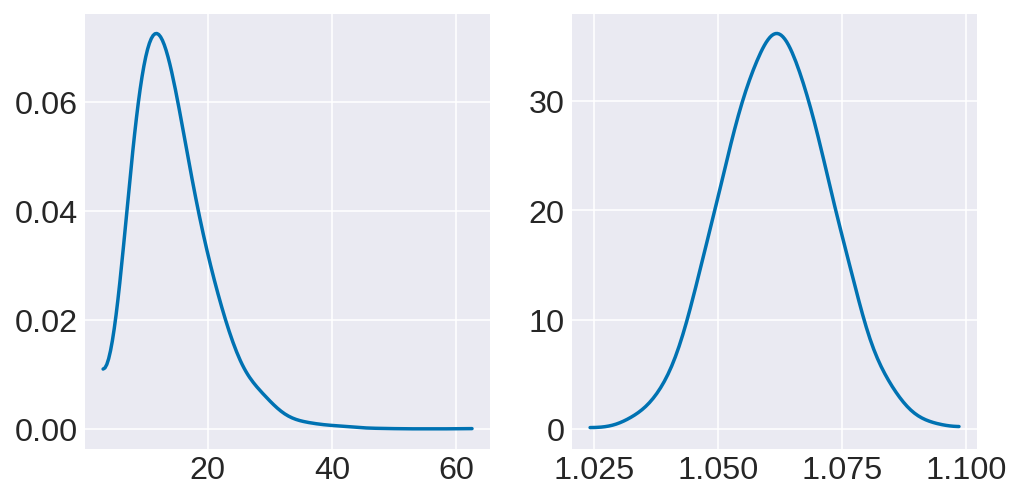

In [72]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
pm.kdeplot(big, ax=ax[0])
pm.kdeplot(small, ax=ax[1]);

#### Code 4.5
Normal by log-multiplication: But wait, Large deviates that are multiplied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale.

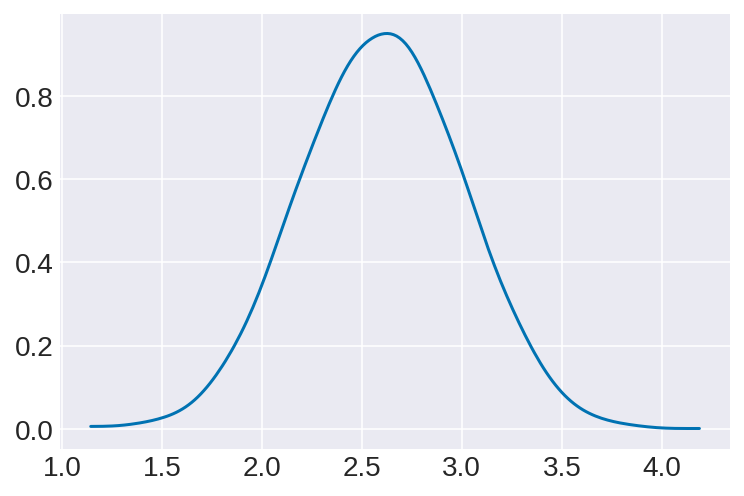

In [73]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
pm.kdeplot(log_big);

#### Code 4.6
Al anguage for describing models:
1) First, we recognize a set of variables that we wish to understand. Some of these variables are observable. We call these data. Others are unobservable things like rates and averages. We call these parameters.
(2) For each variable, we define it either in terms of the other variables or in terms of a probability distribution. These definitions make it possible to learn about associ- ations between variables.
(3) Thecombinationofvariablesandtheirprobabilitydistributionsdefinesajointgen- erative model that can be used both to simulate hypothetical observations as well as analyze real ones.
Once a scientist learns this language, it becomes easier to communicate the assumptions of our models. We no longer have to remember seemingly arbitrary lists of bizarre conditions like homoscedasticity (constant variance), because we can just read these conditions from the model definitions. We will also be able to see natural ways to change these assumptions, instead of feeling trapped within some procrustean model type, like regression or multiple regression or ANOVA or ANCOVA or such

Re-describing the globe tossing model: It’s good to work with examples. Recall the proportion of water problem from previous chapters. The model in that case was always:

W ∼ Binomial(N, p)

 p ∼ Uniform(0, 1)

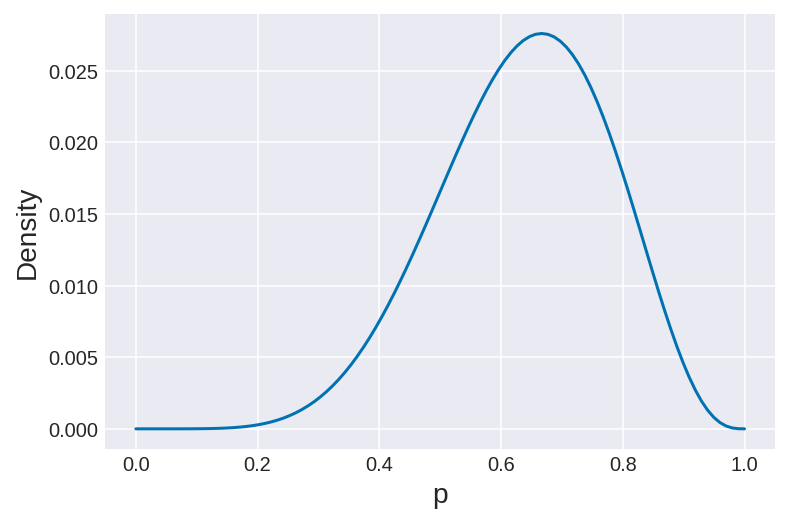

In [74]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel('p', fontsize=14)
plt.ylabel('Density', fontsize=14);

#### Code 4.7 and 4.8
We’ll work through this material by using real sets of data. In this case, we want a single measurement variable to model as a Gaussian distribution. There will be two parameters describing the distribution’s shape, the mean μ and the standard deviation σ. Bayesian up- dating will allow us to consider every possible combination of values for μ and σ and to score each combination by its relative plausibility, in light of the data. These relative plausibilities are the posterior probabilities of each combination of values μ, σ.
Another way to say the above is this. There are an infinite number of possible Gaussian distributions. Some have small means. Others have large means. Some are wide, with a large σ. Others are narrow. We want our Bayesian machine to consider every possible distribution, each defined by a combination of μ and σ, and rank them by posterior plausibility. Posterior plausibility provides a measure of the logical compatibility of each possible distribution with the data and model.
In practice we’ll use approximations to the formal analysis. So we won’t really consider every possible value of μ and σ. But that won’t cost us anything in most cases. Instead the thing to worry about is keeping in mind that the “estimate” here will be the entire posterior distribution, not any point within it. And as a result, the posterior distribution will be a distribution of Gaussian distributions. Yes, a distribution of distributions

In [0]:
url="https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"

In [76]:
d = pd.read_csv(url, sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

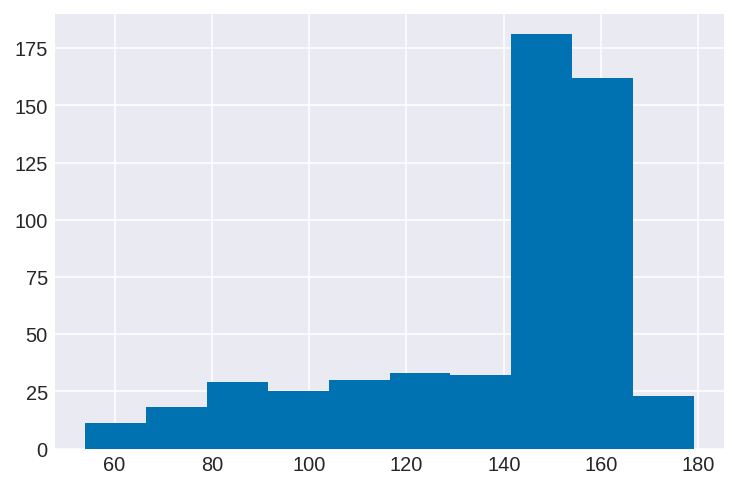

In [77]:
#d.height.hist()# draw the hist, adult heights from a single population are nearly always approximately normal.
data=d[d["height"]>18]
data["height"].hist()

Assumption Data is gaussian distributed;
likelyhood Gaussian .

So it’s reasonable for the moment to adopt the stance that the model should use a Gauss- ian distribution for the probability distribution of the data. 
So which Gaussian distribution? There are an infinite number of them, with an infinite number of different means and standard deviations. We’re ready to write down the general model and compute the plausibility of each combination of μ and σ. To define the heights as normally distributed with a mean μ and standard deviation σ, we write:

$ h_i ∼ Normal(μ, σ)$

What are the priors

$$μ ∼ Normal(178, 20)$$

$$ σ ∼ Uniform(0, 50)$$



#### Code 4.10

In [0]:
d2 = d[d.age >= 18]

#### Code 4.11

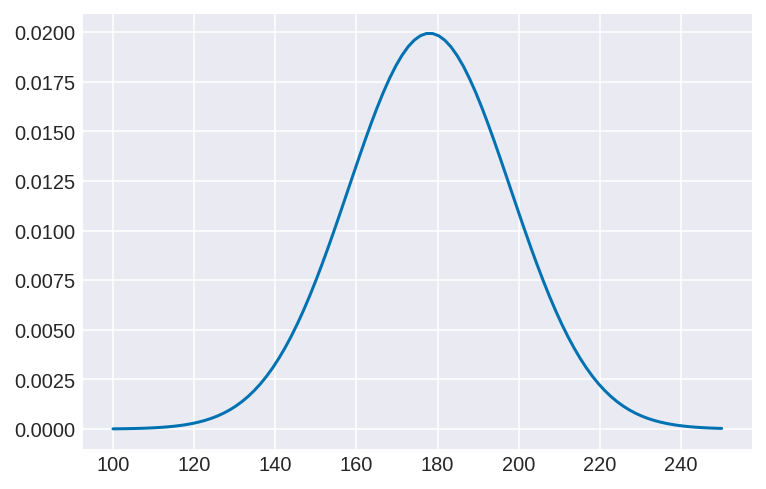

In [79]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.12

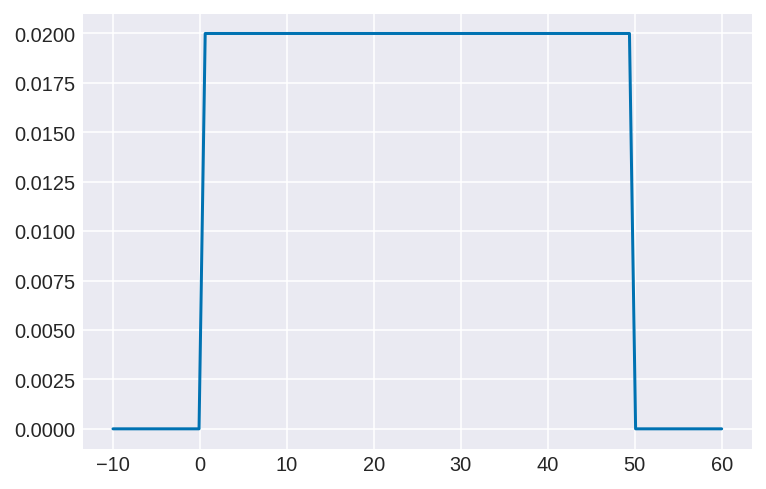

In [80]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.13
All this talk is nice, but it’ll help to really see what these priors imply about the distribu- tion of individual heights. This is an essential part of your modeling, the **prior predictive** simulation. Once you’ve chosen priors for h, μ, and σ, these imply a joint prior distribution of individual heights. By simulating from this distribution, you can see what your choices imply about observable height. This helps you diagnose bad choices.

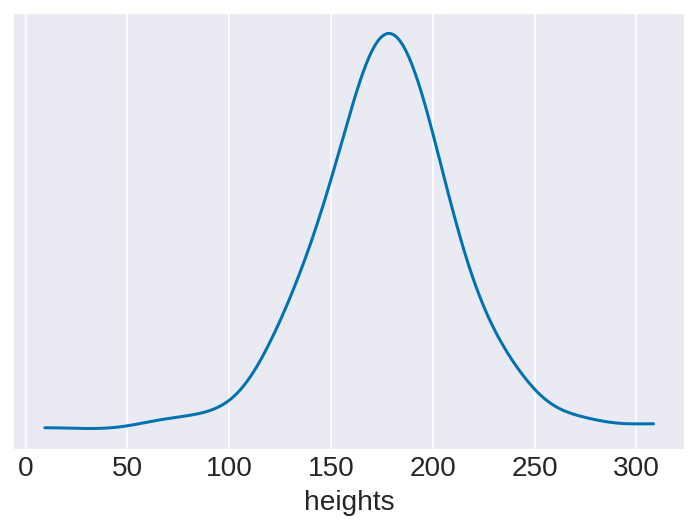

In [81]:
n_samples = 1000 #stats.norm.pdf(x, 178, 20)
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)#masum köylü=data görmemiş likelyhood
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

Does this matter? It is true is this case that we have so much data that even this silly prior is harmless. But that won’t always be the case. There are plenty of inference problems for which the data alone are not sufficient, no matter how numerous.


$$Pr(μ,σ)=\frac{\prod_{i} Normal(μ_i, σ) Normal(178, 20) Uniform(0, 50)}{\iint \prod_{i} Normal(μ_i
, σ) Normal(178, 20) Uniform(0, 50) dμ dσ}$$

#### Code 4.14
Grid aproximation

In [82]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T
post

array([[140. ,   4. ],
       [140. ,   4.1],
       [140. ,   4.2],
       ...,
       [159.9,   8.7],
       [159.9,   8.8],
       [159.9,   8.9]])

In [83]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))
post_prob

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.65047617e-31, 1.02513172e-30, 1.66718940e-30])

#### Code 4.15 and 4.16

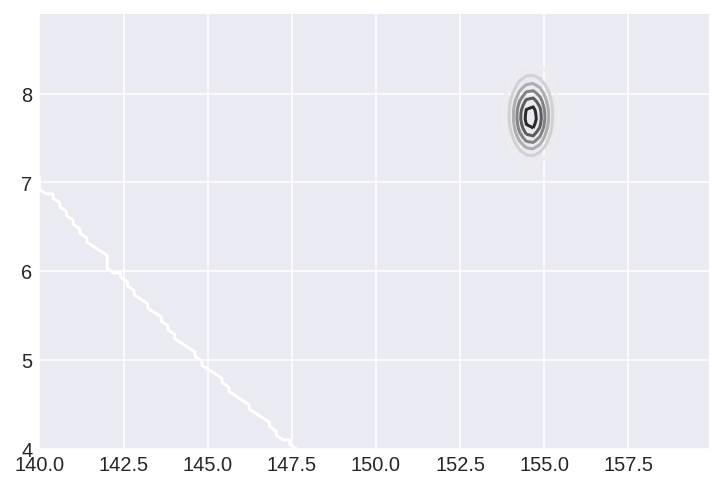

In [84]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.17 and 4.18

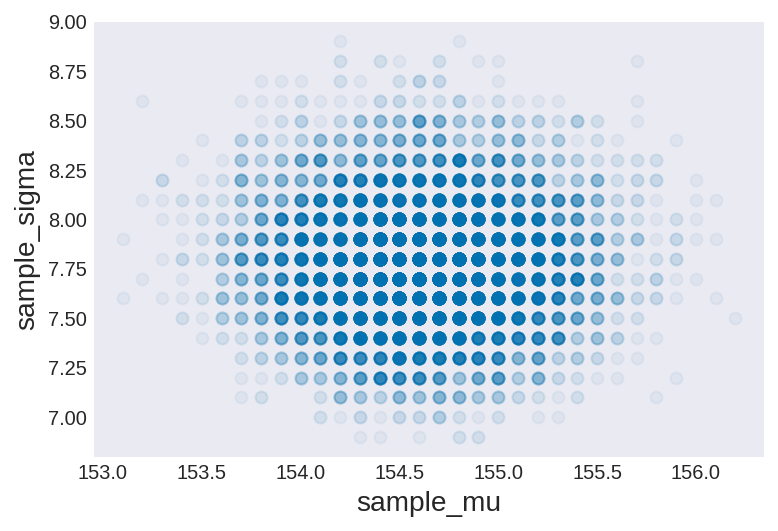

In [85]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu', fontsize=14)
plt.ylabel('sample_sigma', fontsize=14);

#### Code 4.19

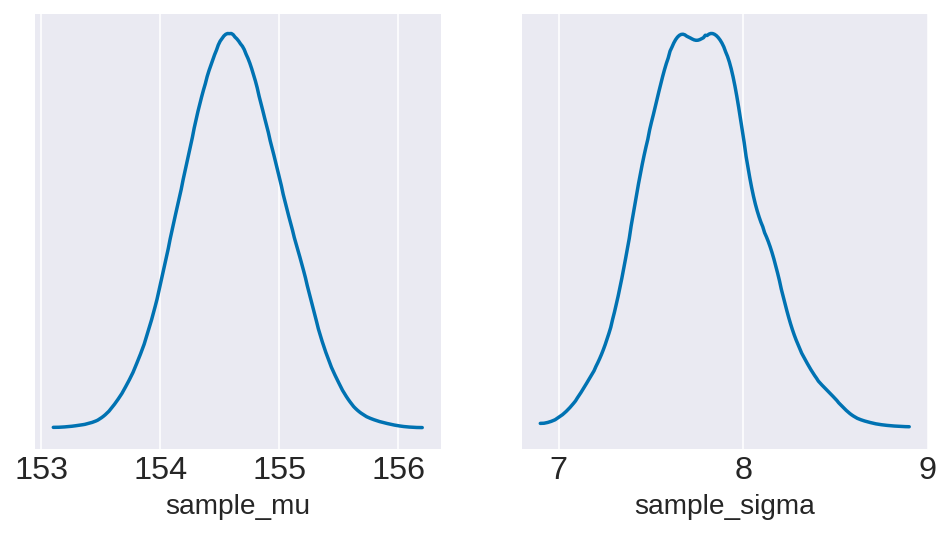

In [86]:
_, ax = plt.subplots(1,2, figsize=(8,4))
pm.kdeplot(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu', fontsize=14)
ax[0].set_yticks([])
pm.kdeplot(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma', fontsize=14)
ax[1].set_yticks([]);

#### Code 4.20

In [87]:
pm.hpd(sample_mu), pm.hpd(sample_sigma)

(array([153.8, 155.3]), array([7.3, 8.3]))

#### Code 4.21 and  4.22
Before moving on to using quadratic approximation (quap) as shortcut to all of this inference, it is worth repeating the analysis of the height data above, but now with only a fraction of the original data. The reason to do this is to demonstrate that, in principle, the posterior is not always so Gaussian in shape. There’s no trouble with the mean, μ. For a Gaussian likelihood and a Gaussian prior on μ, the posterior distribution is always Gaussian as well, regardless of sample size. It is the standard deviation σ that causes problems. So if you care about σ—often people do not—you do need to be careful of abusing the quadratic approximation

In [0]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod2 = (likelihood + 
              stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod - max(post_prod))

sample_rows2 = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu2 = post[:,0][sample_rows]
sample_sigma2 = post[:,1][sample_rows]

##Here adopt the graph above for 20 data!!!

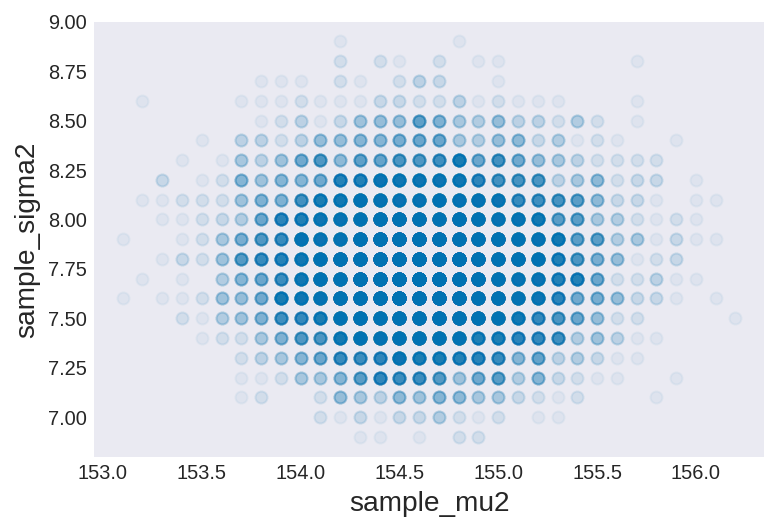

In [89]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2', fontsize=14)
plt.ylabel('sample_sigma2', fontsize=14)
plt.grid(False)

#### Code 4.23

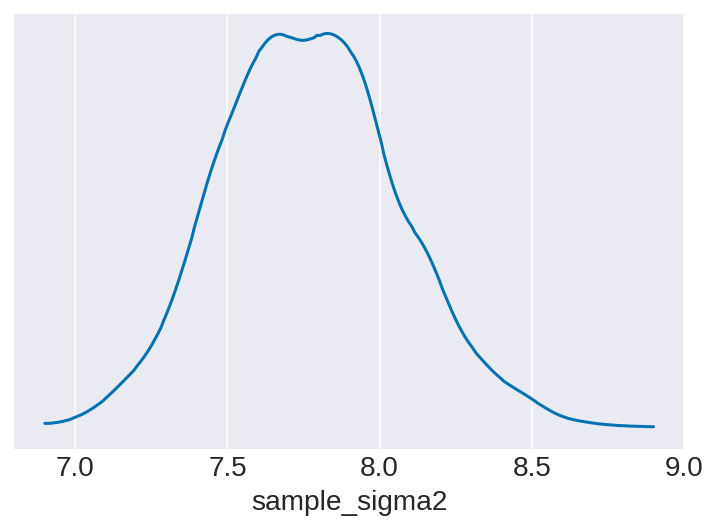

In [90]:
pm.kdeplot(sample_sigma2)
plt.xlabel('sample_sigma2', fontsize=14)
plt.yticks([]);

#### Code 4.24

We are repeating code 4.7, 4.8 and 4.10

In [0]:
d = pd.read_csv(url, sep=';', header=0)
d2 = d[d.age >= 18]

#### Code 4.25

In [0]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

#### Code 4.26

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various sampler. Some sampler are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [93]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1360.02it/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

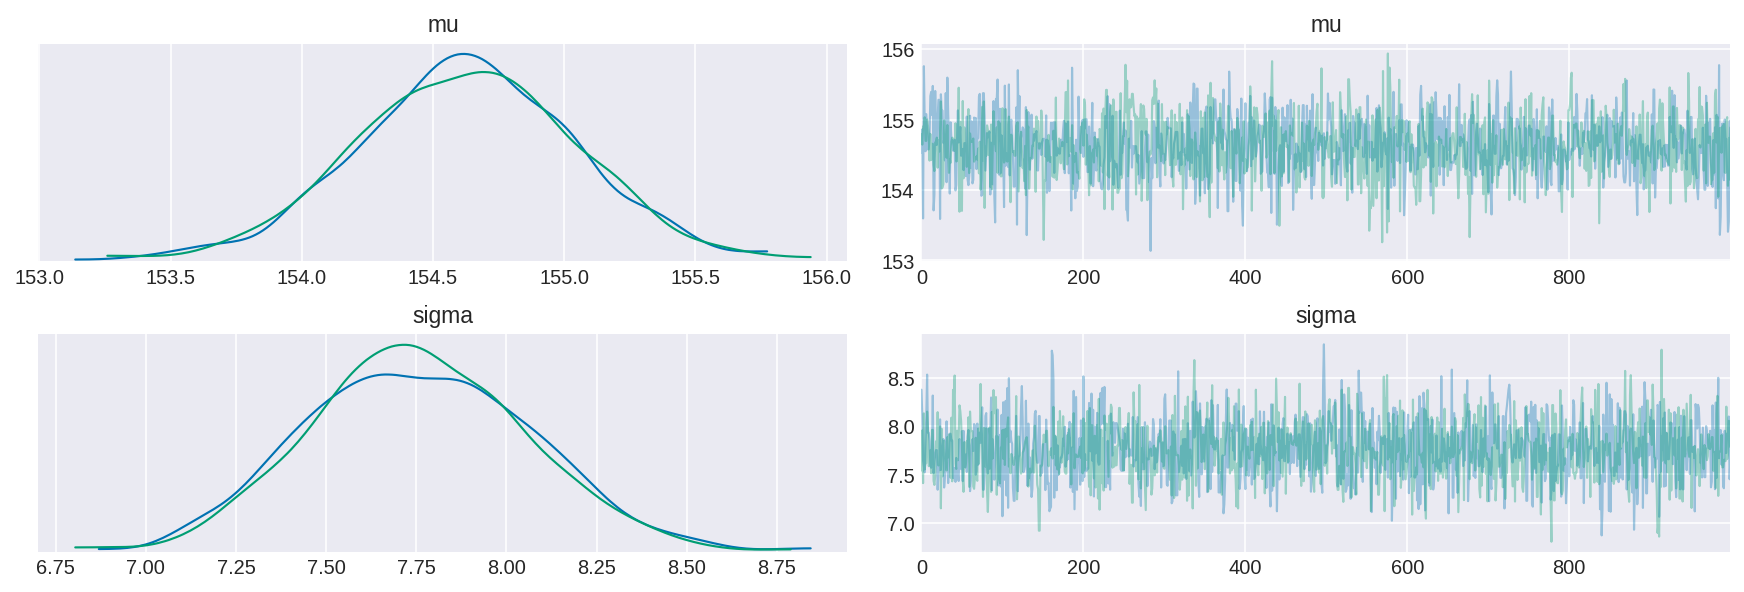

In [94]:
pm.traceplot(trace_4_1); # this function let you check the samples values

#### Code 4.27

Notice that comapred to the table in the book we have an extra column, "mc_error". Since we are sampling from the posterior, there is an error introducing by the sampling process. This error can be reduced by taking more samples.

In [95]:
!pip install pymc3

In [96]:
pm.summary(trace_4_1).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.62,0.41,153.85,155.39,0.01,0.01,1824.0,1822.0,1803.0,1376.0,1.0
sigma,7.76,0.30,7.22,8.33,0.01,0.00,1877.0,1876.0,1879.0,1352.0,1.0


#### Code 4.28

In [97]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1378.00it/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.61,0.41,153.87,155.39,0.01,0.01,1769.0,1768.0,1761.0,1295.0,1.0
sigma,7.75,0.31,7.20,8.32,0.01,0.00,1792.0,1787.0,1803.0,1433.0,1.0


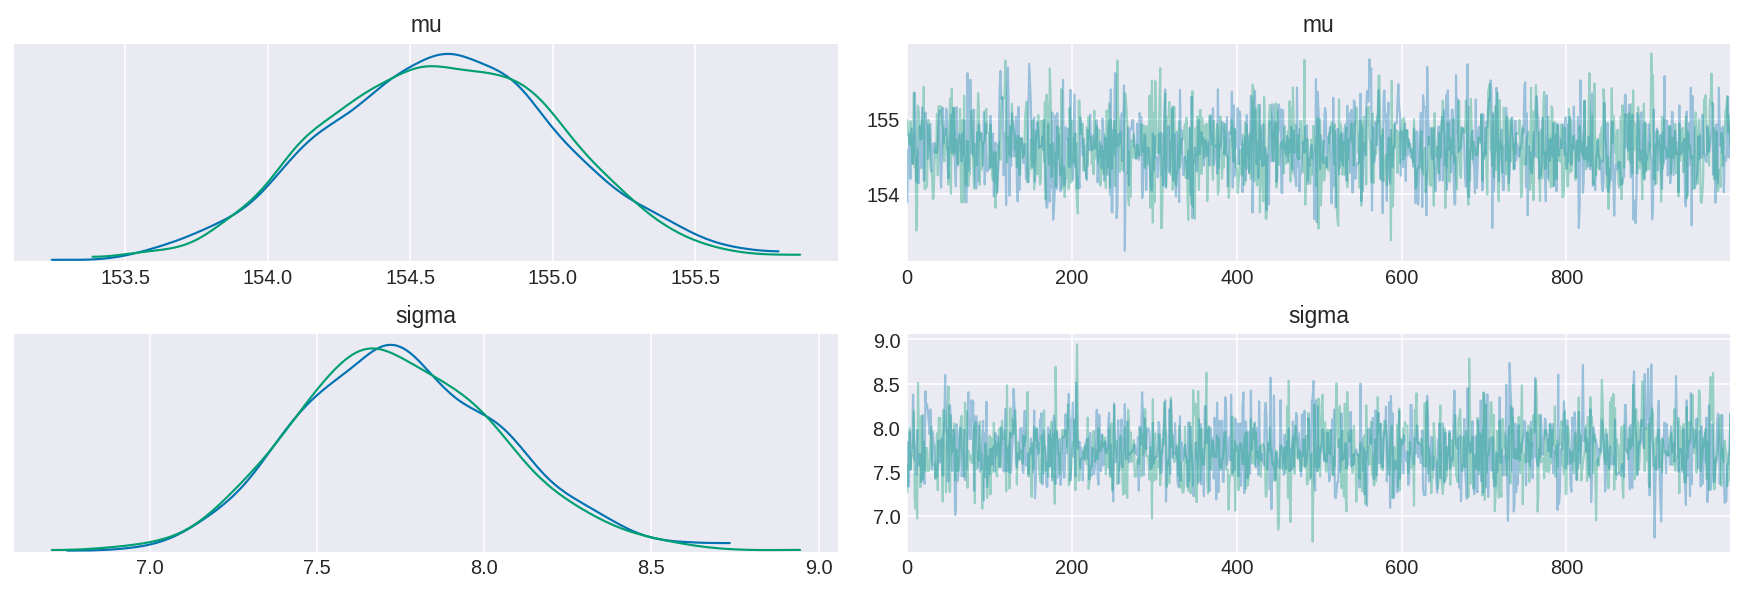

In [98]:
pm.traceplot(trace_4_1); 
pm.summary(trace_4_1).round(2)

#### Code 4.29

In [99]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1351.86it/s]


In [100]:
pm.summary(trace_4_2).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,177.87,0.10,177.69,178.06,0.00,0.00,1648.0,1648.0,1652.0,1320.0,1.00
sigma,24.58,0.94,22.80,26.23,0.02,0.02,1817.0,1807.0,1825.0,1426.0,1.01


#### Code 4.30

For some computations could be nice to have the trace turned into a DataFrame, this can be donde using the "trace_to_dataframe" function

In [101]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.167386,0.002425
sigma,0.002425,0.094152


#### Code 4.31

In [102]:
np.diag(trace_df.cov())

array([0.16738605, 0.09415165])

In [103]:
trace_df.corr()

,mu,sigma
mu,1.000000,0.019318
sigma,0.019318,1.000000


#### Code 4.32

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [104]:
trace_df.head()

,mu,sigma
0,153.885840,7.836158
1,154.586746,7.336082
2,154.586746,7.336082
3,154.800815,7.952716
4,154.197828,7.532294


Or directly from the trace (we are getting the first ten samples of _sigma_)

In [105]:
trace_4_1['sigma'][:10]

array([7.83615833, 7.33608247, 7.33608247, 7.95271597, 7.532294  ,
       7.77519681, 7.77265919, 8.37484101, 7.94487905, 7.62988023])

#### Code 4.33

In our case, this is the same we did in the code 4.27

In [106]:
pm.summary(trace_4_1).round(2)

TypeError: ignored

#### Code 4.34

In [0]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

#### Code 4.35 and 4.36

Instead of sampling from a normal and then exponentiating to ensure sigma is positive, we can use the lognormal distribution for the same result. The Lognormal distribution is parametrized in terms of $\tau$ (tau) the precision and not the standard deviation, where: 

$$tau=\frac{1}{sd^2}$$

The normal distribution can also be parametrized in terms of the precision (tau). Given that the conversion between both parametrization is done right, which one to use is only a matter of convenience. 

In [0]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

In [0]:
pm.traceplot(trace_4_1_logsigma);

#### Code 4.37

In [0]:
plt.plot(d2.height, d2.weight, '.');

#### Code 4.38 and 4.39

Notice that the variable mu is defined as alpha + beta * d2.weight in a single line. If we want the trace to containt mu we can write as a deterministic varible. The computating will be exactly the same. The only diference is that mu will be accesible in the trace.

In [0]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

In [0]:
pm.traceplot(trace_4_3);

Another alternative is to write mu inside the likelihood and not as a separate line.

    height = pm.Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)
    
Using PyMC3 there is not too much reason to do this. I personally think that defining mu in a separate lines improves readability.

#### Code 4.40

In [0]:
pm.summary(trace_4_3).round(2)

#### Code 4.41

In [0]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

#### Code 4.42

In [0]:
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))

#### Code 4.43

In [0]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

#### Code 4.44

In [0]:
pm.summary(trace_4_4).round(2)

#### Code 4.45

Instead of using the MAP, we are going to use the mean of the posterior 

In [0]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### Code 4.46 and 4.47

In [0]:
pm.trace_to_dataframe(trace_4_4)[:5]

#### Code 4.48

In [0]:
N = [10, 50, 150, 352][0]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)

In [0]:
chain_N = trace_N[100:]
pm.traceplot(chain_N);

#### Code 4.49

In [0]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'C2-', alpha=0.5)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

Alternative we can directly use the deterministic mu variable

In [0]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['mu'][idx], 'C2-', alpha=0.5)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

#### Code 4.50 and 4.51

In [0]:
mu_at_50 = chain_N['alpha'] + chain_N['beta'] * 50
pm.kdeplot(mu_at_50)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

#### Code 4.52

In [0]:
pm.hpd(mu_at_50)

#### Code 4.53

Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need.

In [0]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

#### Code 4.54 and 4.58

We are doing _manually_, what in thebook is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [0]:
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

#### Code 4.55

In [0]:
plt.plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14);

#### Code 4.56

In [0]:
mu_mean = mu_pred.mean(1)
mu_hpd = pm.hpd(mu_pred.T)

#### Code 4.57

In [0]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weigth_seq, mu_mean, 'C2')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.59

Now we are going to use ```sample_ppc()``` from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)

In [0]:
height_pred = pm.sample_ppc(chain_N, 200, m_N)

#### Code 4.60

In [0]:
height_pred_hpd = pm.hpd(height_pred['height_hat'])

#### Code 4.61
```sample_ppc``` returns values corresponding to the input values (weights in this example). Because the weights are not ordered if we use them with the ```fill_between``` function we will get a mess. For that reason in the following cell we order the weights and the predicted heights

In [0]:
idx = np.argsort(d2.weight.values[:N])
d2_weight_ord = d2.weight.values[:N][idx]
height_pred_hpd = height_pred_hpd[idx]

In [0]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(d2_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)
plt.plot(weigth_seq, mu_mean, 'C2')
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values. Because we are getting samples at the input values the jaggedness of this plot is larger than the one in the book.

#### Code 4.63

Now we are going to generate heights from the posterior _manually_, instead of restricting to the input values we are going to pass an array of equally spaced weights values ```weight_seg```.

In [0]:
weigth_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(chain_N))
    mu_pred = chain_N['alpha'][i] + chain_N['beta'][i] * weigth_seq
    sigma_pred = chain_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pred, sigma_pred))

In [0]:
post_samples_hpd = pm.hpd(np.array(post_samples))

In [0]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weigth_seq, mu_mean, 'C2')
plt.fill_between(weigth_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(weigth_seq, post_samples_hpd[:,0], post_samples_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [0]:
d.head()

#### Code 4.65

In [0]:
d.weight_std = (d.weight - d.weight.mean()) / d.weight.std()
d.weight_std2 = d.weight_std**2

#### Code 4.66

In [0]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

In [0]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace_4_5, varnames);

#### Code 4.67

In [0]:
pm.summary(trace_4_5, varnames).round(2)

#### Code 4.68

In [0]:
mu_pred = trace_4_5['mu']
idx = np.argsort(d.weight_std)
mu_hpd = pm.hpd(mu_pred)[idx]

height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)
height_pred_hpd = pm.hpd(height_pred['height'])[idx]

#### Code 4.69

In [0]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25);

#### Code 4.70

We will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array

In [0]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [0]:
with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

In [0]:
pm.traceplot(trace_4_6, varnames);

#### Code 4.71 and 4.72

In [0]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
plt.fill_between(d.weight_std[idx], mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25);
plt.fill_between(d.weight_std[idx], height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [0]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))